In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from label_legends.preprocess import load_test, transform, holdout
from label_legends.result import calculate_scores, get_experiment, load_predictions, client, get_current
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AutoConfig, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import json
import torch
import mlflow
import polars as pl
import logging
import time
import numpy as np

logging.basicConfig(level=logging.INFO)

/Users/retipeter/Documents/TU Wien/NLP/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test = transform(load_test().collect())
val, tra = holdout()
tra = transform(tra)
val = transform(val)

/Users/retipeter/Documents/TU Wien/NLP/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
MODEL_NAME = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer =DistilBertTokenizer.from_pretrained(MODEL_NAME)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
class SexistDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_texts = tra['text'].to_list()
train_labels = tra['label'].to_list()

val_texts = val['text'].to_list()
val_labels = val['label'].to_list()

test_texts = test['text'].to_list()
test_labels = test['label'].to_list()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt",)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt",)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt",)

train_dataset = SexistDataset(train_encodings, train_labels)
val_dataset = SexistDataset(val_encodings, val_labels)
test_dataset = SexistDataset(test_encodings, test_labels)

In [6]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distil',
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    # weight_decay=0.01,
    logging_dir='./logs',
    # save_total_limit=2,
    evaluation_strategy="epoch",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

/Users/retipeter/Documents/TU Wien/NLP/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
start_time = time.time()
train_output = trainer.train()  # Returns a TrainOutput object
training_time_manual = time.time() - start_time
train_metrics = train_output.metrics  # Contains train_runtime, train_loss, etc.

# Assume trainer.evaluate() has been run and returned results
eval_results = trainer.evaluate()  # Contains eval_runtime, eval_accuracy, etc.

# Combine training and evaluation metrics
#all_metrics = {**train_metrics, **eval_results}
metrics = {**eval_results}

# Create a Polars DataFrame
df = pl.DataFrame(metrics)
df

  0%|          | 0/11025 [00:00<?, ?it/s]/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_79185/4111057971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  1%|          | 101/11025 [00:20<23:28,  7.76it/s] 

{'loss': 0.5552, 'grad_norm': 2.663567543029785, 'learning_rate': 4.9546485260770975e-05, 'epoch': 0.03}


  2%|▏         | 201/11025 [00:32<21:52,  8.25it/s]

{'loss': 0.4652, 'grad_norm': 8.831339836120605, 'learning_rate': 4.9092970521541954e-05, 'epoch': 0.05}


  3%|▎         | 301/11025 [00:44<26:10,  6.83it/s]

{'loss': 0.4897, 'grad_norm': 2.9895286560058594, 'learning_rate': 4.8639455782312926e-05, 'epoch': 0.08}


  4%|▎         | 401/11025 [00:56<21:11,  8.35it/s]

{'loss': 0.4625, 'grad_norm': 1.5169730186462402, 'learning_rate': 4.8185941043083905e-05, 'epoch': 0.11}


  5%|▍         | 501/11025 [01:08<22:03,  7.95it/s]

{'loss': 0.4199, 'grad_norm': 3.2922539710998535, 'learning_rate': 4.773242630385488e-05, 'epoch': 0.14}


  5%|▌         | 601/11025 [01:20<21:14,  8.18it/s]

{'loss': 0.4698, 'grad_norm': 3.853856325149536, 'learning_rate': 4.7278911564625856e-05, 'epoch': 0.16}


  6%|▋         | 701/11025 [01:33<20:44,  8.30it/s]

{'loss': 0.4554, 'grad_norm': 1.7814861536026, 'learning_rate': 4.682539682539683e-05, 'epoch': 0.19}


  7%|▋         | 801/11025 [01:45<21:04,  8.09it/s]

{'loss': 0.4353, 'grad_norm': 5.482991695404053, 'learning_rate': 4.63718820861678e-05, 'epoch': 0.22}


  8%|▊         | 901/11025 [01:57<20:47,  8.11it/s]

{'loss': 0.4576, 'grad_norm': 3.7085278034210205, 'learning_rate': 4.591836734693878e-05, 'epoch': 0.24}


  9%|▉         | 1001/11025 [02:09<20:22,  8.20it/s]

{'loss': 0.4257, 'grad_norm': 3.3737380504608154, 'learning_rate': 4.546485260770975e-05, 'epoch': 0.27}


 10%|▉         | 1101/11025 [02:21<20:00,  8.27it/s]

{'loss': 0.4406, 'grad_norm': 1.8825252056121826, 'learning_rate': 4.501133786848073e-05, 'epoch': 0.3}


 11%|█         | 1201/11025 [02:33<19:49,  8.26it/s]

{'loss': 0.4043, 'grad_norm': 3.8866350650787354, 'learning_rate': 4.4557823129251704e-05, 'epoch': 0.33}


 12%|█▏        | 1301/11025 [02:45<19:38,  8.25it/s]

{'loss': 0.4249, 'grad_norm': 10.288155555725098, 'learning_rate': 4.410430839002268e-05, 'epoch': 0.35}


 13%|█▎        | 1401/11025 [02:57<19:36,  8.18it/s]

{'loss': 0.4164, 'grad_norm': 3.0703256130218506, 'learning_rate': 4.3650793650793655e-05, 'epoch': 0.38}


 14%|█▎        | 1501/11025 [03:09<19:14,  8.25it/s]

{'loss': 0.4215, 'grad_norm': 1.8350766897201538, 'learning_rate': 4.319727891156463e-05, 'epoch': 0.41}


 15%|█▍        | 1601/11025 [03:21<19:10,  8.19it/s]

{'loss': 0.4237, 'grad_norm': 4.055550575256348, 'learning_rate': 4.2743764172335606e-05, 'epoch': 0.44}


 15%|█▌        | 1701/11025 [03:33<18:45,  8.28it/s]

{'loss': 0.4582, 'grad_norm': 5.49190616607666, 'learning_rate': 4.229024943310658e-05, 'epoch': 0.46}


 16%|█▋        | 1801/11025 [03:45<19:07,  8.04it/s]

{'loss': 0.3917, 'grad_norm': 4.04637336730957, 'learning_rate': 4.183673469387756e-05, 'epoch': 0.49}


 17%|█▋        | 1901/11025 [03:58<18:21,  8.28it/s]

{'loss': 0.3977, 'grad_norm': 2.628108024597168, 'learning_rate': 4.138321995464853e-05, 'epoch': 0.52}


 18%|█▊        | 2001/11025 [04:10<18:28,  8.14it/s]

{'loss': 0.4058, 'grad_norm': 1.1988229751586914, 'learning_rate': 4.09297052154195e-05, 'epoch': 0.54}


 19%|█▉        | 2101/11025 [04:22<18:01,  8.25it/s]

{'loss': 0.3831, 'grad_norm': 2.2868051528930664, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}


 20%|█▉        | 2201/11025 [04:34<17:55,  8.21it/s]

{'loss': 0.3735, 'grad_norm': 7.340250492095947, 'learning_rate': 4.002267573696145e-05, 'epoch': 0.6}


 21%|██        | 2301/11025 [04:46<28:34,  5.09it/s]

{'loss': 0.422, 'grad_norm': 11.776342391967773, 'learning_rate': 3.956916099773243e-05, 'epoch': 0.63}


 22%|██▏       | 2401/11025 [04:59<17:19,  8.30it/s]

{'loss': 0.418, 'grad_norm': 4.233396530151367, 'learning_rate': 3.9115646258503405e-05, 'epoch': 0.65}


 23%|██▎       | 2501/11025 [05:11<17:13,  8.25it/s]

{'loss': 0.3978, 'grad_norm': 3.1458358764648438, 'learning_rate': 3.8662131519274384e-05, 'epoch': 0.68}


 24%|██▎       | 2601/11025 [05:23<17:25,  8.06it/s]

{'loss': 0.4072, 'grad_norm': 7.710434436798096, 'learning_rate': 3.8208616780045356e-05, 'epoch': 0.71}


 24%|██▍       | 2701/11025 [05:35<17:10,  8.08it/s]

{'loss': 0.3895, 'grad_norm': 2.8002097606658936, 'learning_rate': 3.775510204081633e-05, 'epoch': 0.73}


 25%|██▌       | 2801/11025 [05:47<16:29,  8.31it/s]

{'loss': 0.393, 'grad_norm': 5.00508451461792, 'learning_rate': 3.730158730158731e-05, 'epoch': 0.76}


 26%|██▋       | 2901/11025 [05:59<16:19,  8.30it/s]

{'loss': 0.4048, 'grad_norm': 0.44633370637893677, 'learning_rate': 3.684807256235828e-05, 'epoch': 0.79}


 27%|██▋       | 3001/11025 [06:11<16:07,  8.29it/s]

{'loss': 0.3692, 'grad_norm': 5.437313079833984, 'learning_rate': 3.639455782312925e-05, 'epoch': 0.82}


 28%|██▊       | 3101/11025 [06:23<15:53,  8.31it/s]

{'loss': 0.3798, 'grad_norm': 0.4914639890193939, 'learning_rate': 3.594104308390023e-05, 'epoch': 0.84}


 29%|██▉       | 3201/11025 [06:36<15:58,  8.16it/s]

{'loss': 0.3757, 'grad_norm': 3.498560667037964, 'learning_rate': 3.54875283446712e-05, 'epoch': 0.87}


 30%|██▉       | 3301/11025 [06:48<15:35,  8.26it/s]

{'loss': 0.3979, 'grad_norm': 2.125828742980957, 'learning_rate': 3.5034013605442175e-05, 'epoch': 0.9}


 31%|███       | 3401/11025 [07:00<15:21,  8.28it/s]

{'loss': 0.4137, 'grad_norm': 3.758382797241211, 'learning_rate': 3.4580498866213154e-05, 'epoch': 0.93}


 32%|███▏      | 3501/11025 [07:12<15:35,  8.04it/s]

{'loss': 0.3646, 'grad_norm': 9.222282409667969, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 33%|███▎      | 3601/11025 [07:25<15:08,  8.17it/s]

{'loss': 0.4398, 'grad_norm': 2.0940799713134766, 'learning_rate': 3.36734693877551e-05, 'epoch': 0.98}


                                                    
 33%|███▎      | 3675/11025 [08:31<14:51,  8.24it/s]

{'eval_loss': 0.35539954900741577, 'eval_accuracy': 0.8587301587301587, 'eval_f1': 0.8587301587301587, 'eval_precision': 0.8587301587301587, 'eval_recall': 0.8587301587301587, 'eval_runtime': 57.221, 'eval_samples_per_second': 220.199, 'eval_steps_per_second': 27.525, 'epoch': 1.0}


/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_79185/4111057971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 34%|███▎      | 3701/11025 [08:35<15:06,  8.08it/s]   

{'loss': 0.3891, 'grad_norm': 0.7580999135971069, 'learning_rate': 3.321995464852608e-05, 'epoch': 1.01}


 34%|███▍      | 3801/11025 [08:47<14:33,  8.27it/s]

{'loss': 0.3193, 'grad_norm': 4.29052209854126, 'learning_rate': 3.276643990929705e-05, 'epoch': 1.03}


 35%|███▌      | 3901/11025 [08:59<15:03,  7.89it/s]

{'loss': 0.2981, 'grad_norm': 6.142706871032715, 'learning_rate': 3.231292517006803e-05, 'epoch': 1.06}


 36%|███▋      | 4001/11025 [09:12<14:22,  8.15it/s]

{'loss': 0.3407, 'grad_norm': 7.381734371185303, 'learning_rate': 3.1859410430839e-05, 'epoch': 1.09}


 37%|███▋      | 4101/11025 [09:24<14:16,  8.09it/s]

{'loss': 0.35, 'grad_norm': 5.599763870239258, 'learning_rate': 3.1405895691609974e-05, 'epoch': 1.12}


 38%|███▊      | 4201/11025 [09:37<13:49,  8.23it/s]

{'loss': 0.2894, 'grad_norm': 7.763638973236084, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}


 39%|███▉      | 4301/11025 [09:49<14:14,  7.87it/s]

{'loss': 0.3146, 'grad_norm': 1.0759515762329102, 'learning_rate': 3.049886621315193e-05, 'epoch': 1.17}


 40%|███▉      | 4401/11025 [10:01<13:20,  8.27it/s]

{'loss': 0.3306, 'grad_norm': 11.069677352905273, 'learning_rate': 3.0045351473922904e-05, 'epoch': 1.2}


 41%|████      | 4501/11025 [10:14<13:39,  7.96it/s]

{'loss': 0.3003, 'grad_norm': 1.5195947885513306, 'learning_rate': 2.959183673469388e-05, 'epoch': 1.22}


 42%|████▏     | 4601/11025 [10:26<12:52,  8.32it/s]

{'loss': 0.3248, 'grad_norm': 6.844991683959961, 'learning_rate': 2.9138321995464856e-05, 'epoch': 1.25}


 43%|████▎     | 4701/11025 [10:38<13:18,  7.92it/s]

{'loss': 0.3117, 'grad_norm': 5.489810943603516, 'learning_rate': 2.8684807256235828e-05, 'epoch': 1.28}


 44%|████▎     | 4801/11025 [10:50<12:49,  8.08it/s]

{'loss': 0.3473, 'grad_norm': 5.676605701446533, 'learning_rate': 2.8231292517006803e-05, 'epoch': 1.31}


 44%|████▍     | 4901/11025 [11:02<13:26,  7.60it/s]

{'loss': 0.2899, 'grad_norm': 4.669692516326904, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


 45%|████▌     | 5001/11025 [11:15<15:19,  6.55it/s]

{'loss': 0.3399, 'grad_norm': 2.101268768310547, 'learning_rate': 2.732426303854875e-05, 'epoch': 1.36}


 46%|████▋     | 5101/11025 [11:28<12:06,  8.15it/s]

{'loss': 0.3436, 'grad_norm': 6.406872272491455, 'learning_rate': 2.687074829931973e-05, 'epoch': 1.39}


 47%|████▋     | 5201/11025 [11:40<11:50,  8.20it/s]

{'loss': 0.3148, 'grad_norm': 0.481794148683548, 'learning_rate': 2.6417233560090703e-05, 'epoch': 1.41}


 48%|████▊     | 5301/11025 [11:52<11:29,  8.30it/s]

{'loss': 0.3861, 'grad_norm': 0.8324896097183228, 'learning_rate': 2.5963718820861675e-05, 'epoch': 1.44}


 49%|████▉     | 5401/11025 [12:04<11:19,  8.27it/s]

{'loss': 0.2582, 'grad_norm': 6.690565586090088, 'learning_rate': 2.5510204081632654e-05, 'epoch': 1.47}


 50%|████▉     | 5501/11025 [12:16<11:02,  8.34it/s]

{'loss': 0.3329, 'grad_norm': 11.680445671081543, 'learning_rate': 2.5056689342403626e-05, 'epoch': 1.5}


 51%|█████     | 5601/11025 [12:28<10:48,  8.36it/s]

{'loss': 0.3028, 'grad_norm': 6.406045913696289, 'learning_rate': 2.4603174603174602e-05, 'epoch': 1.52}


 52%|█████▏    | 5701/11025 [12:40<10:40,  8.32it/s]

{'loss': 0.3535, 'grad_norm': 10.817100524902344, 'learning_rate': 2.4149659863945578e-05, 'epoch': 1.55}


 53%|█████▎    | 5801/11025 [12:52<10:32,  8.26it/s]

{'loss': 0.3137, 'grad_norm': 9.61841869354248, 'learning_rate': 2.3696145124716553e-05, 'epoch': 1.58}


 54%|█████▎    | 5901/11025 [13:04<10:14,  8.33it/s]

{'loss': 0.2927, 'grad_norm': 2.39034366607666, 'learning_rate': 2.324263038548753e-05, 'epoch': 1.61}


 54%|█████▍    | 6001/11025 [13:16<10:02,  8.33it/s]

{'loss': 0.3442, 'grad_norm': 5.088446617126465, 'learning_rate': 2.2789115646258505e-05, 'epoch': 1.63}


 55%|█████▌    | 6101/11025 [13:29<10:04,  8.15it/s]

{'loss': 0.3095, 'grad_norm': 1.6018379926681519, 'learning_rate': 2.233560090702948e-05, 'epoch': 1.66}


 56%|█████▌    | 6201/11025 [13:42<09:44,  8.26it/s]

{'loss': 0.3507, 'grad_norm': 3.43674373626709, 'learning_rate': 2.1882086167800456e-05, 'epoch': 1.69}


 57%|█████▋    | 6301/11025 [13:54<09:39,  8.14it/s]

{'loss': 0.3368, 'grad_norm': 2.9075417518615723, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}


 58%|█████▊    | 6401/11025 [14:06<09:17,  8.30it/s]

{'loss': 0.3429, 'grad_norm': 5.762382507324219, 'learning_rate': 2.0975056689342404e-05, 'epoch': 1.74}


 59%|█████▉    | 6501/11025 [14:18<09:05,  8.30it/s]

{'loss': 0.3227, 'grad_norm': 1.5992276668548584, 'learning_rate': 2.052154195011338e-05, 'epoch': 1.77}


 60%|█████▉    | 6601/11025 [14:30<08:57,  8.23it/s]

{'loss': 0.3187, 'grad_norm': 9.637273788452148, 'learning_rate': 2.0068027210884355e-05, 'epoch': 1.8}


 61%|██████    | 6701/11025 [14:42<08:41,  8.29it/s]

{'loss': 0.3538, 'grad_norm': 7.499607563018799, 'learning_rate': 1.961451247165533e-05, 'epoch': 1.82}


 62%|██████▏   | 6801/11025 [14:54<08:31,  8.26it/s]

{'loss': 0.3299, 'grad_norm': 6.956097602844238, 'learning_rate': 1.9160997732426306e-05, 'epoch': 1.85}


 63%|██████▎   | 6901/11025 [15:07<08:19,  8.25it/s]

{'loss': 0.3163, 'grad_norm': 0.36069974303245544, 'learning_rate': 1.8707482993197282e-05, 'epoch': 1.88}


 64%|██████▎   | 7001/11025 [15:19<08:08,  8.25it/s]

{'loss': 0.33, 'grad_norm': 4.785246849060059, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 64%|██████▍   | 7101/11025 [15:31<07:53,  8.28it/s]

{'loss': 0.3375, 'grad_norm': 5.180455207824707, 'learning_rate': 1.780045351473923e-05, 'epoch': 1.93}


 65%|██████▌   | 7201/11025 [15:43<07:42,  8.28it/s]

{'loss': 0.3564, 'grad_norm': 3.8263323307037354, 'learning_rate': 1.7346938775510206e-05, 'epoch': 1.96}


 66%|██████▌   | 7301/11025 [15:55<07:30,  8.27it/s]

{'loss': 0.3465, 'grad_norm': 0.37107500433921814, 'learning_rate': 1.689342403628118e-05, 'epoch': 1.99}


                                                    
 67%|██████▋   | 7350/11025 [16:52<07:27,  8.20it/s]

{'eval_loss': 0.4022426903247833, 'eval_accuracy': 0.8606349206349206, 'eval_f1': 0.8606349206349206, 'eval_precision': 0.8606349206349206, 'eval_recall': 0.8606349206349206, 'eval_runtime': 51.2872, 'eval_samples_per_second': 245.675, 'eval_steps_per_second': 30.709, 'epoch': 2.0}


/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_79185/4111057971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
 67%|██████▋   | 7401/11025 [17:00<07:33,  7.99it/s]   

{'loss': 0.309, 'grad_norm': 0.41062304377555847, 'learning_rate': 1.6439909297052157e-05, 'epoch': 2.01}


 68%|██████▊   | 7501/11025 [17:12<07:16,  8.07it/s]

{'loss': 0.2613, 'grad_norm': 0.20454636216163635, 'learning_rate': 1.5986394557823133e-05, 'epoch': 2.04}


 69%|██████▉   | 7601/11025 [17:25<06:51,  8.32it/s]

{'loss': 0.211, 'grad_norm': 49.776649475097656, 'learning_rate': 1.5532879818594105e-05, 'epoch': 2.07}


 70%|██████▉   | 7701/11025 [17:37<06:39,  8.32it/s]

{'loss': 0.291, 'grad_norm': 0.6803809404373169, 'learning_rate': 1.5079365079365079e-05, 'epoch': 2.1}


 71%|███████   | 7801/11025 [17:49<06:27,  8.32it/s]

{'loss': 0.2574, 'grad_norm': 18.800992965698242, 'learning_rate': 1.4625850340136055e-05, 'epoch': 2.12}


 72%|███████▏  | 7901/11025 [18:01<06:50,  7.60it/s]

{'loss': 0.2328, 'grad_norm': 5.9276299476623535, 'learning_rate': 1.417233560090703e-05, 'epoch': 2.15}


 73%|███████▎  | 8001/11025 [18:13<06:25,  7.85it/s]

{'loss': 0.29, 'grad_norm': 17.61214828491211, 'learning_rate': 1.3718820861678006e-05, 'epoch': 2.18}


 73%|███████▎  | 8101/11025 [18:26<06:03,  8.05it/s]

{'loss': 0.3094, 'grad_norm': 8.182811737060547, 'learning_rate': 1.3265306122448982e-05, 'epoch': 2.2}


 74%|███████▍  | 8201/11025 [18:39<05:47,  8.14it/s]

{'loss': 0.2125, 'grad_norm': 6.249633312225342, 'learning_rate': 1.2811791383219957e-05, 'epoch': 2.23}


 75%|███████▌  | 8301/11025 [18:51<05:57,  7.62it/s]

{'loss': 0.3105, 'grad_norm': 3.9727439880371094, 'learning_rate': 1.2358276643990931e-05, 'epoch': 2.26}


 76%|███████▌  | 8401/11025 [19:04<05:38,  7.75it/s]

{'loss': 0.2684, 'grad_norm': 0.5348494052886963, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}


 77%|███████▋  | 8501/11025 [19:16<05:45,  7.30it/s]

{'loss': 0.2794, 'grad_norm': 11.518877983093262, 'learning_rate': 1.145124716553288e-05, 'epoch': 2.31}


 78%|███████▊  | 8601/11025 [19:29<04:51,  8.31it/s]

{'loss': 0.2807, 'grad_norm': 0.3312242031097412, 'learning_rate': 1.0997732426303856e-05, 'epoch': 2.34}


 79%|███████▉  | 8701/11025 [19:42<04:55,  7.86it/s]

{'loss': 0.2815, 'grad_norm': 3.0962748527526855, 'learning_rate': 1.054421768707483e-05, 'epoch': 2.37}


 80%|███████▉  | 8801/11025 [19:54<04:36,  8.03it/s]

{'loss': 0.2754, 'grad_norm': 1.2252637147903442, 'learning_rate': 1.0090702947845804e-05, 'epoch': 2.39}


 81%|████████  | 8901/11025 [20:07<04:21,  8.11it/s]

{'loss': 0.2498, 'grad_norm': 11.074036598205566, 'learning_rate': 9.63718820861678e-06, 'epoch': 2.42}


 82%|████████▏ | 9001/11025 [20:19<04:06,  8.22it/s]

{'loss': 0.3, 'grad_norm': 6.980609893798828, 'learning_rate': 9.183673469387756e-06, 'epoch': 2.45}


 83%|████████▎ | 9101/11025 [20:31<03:57,  8.12it/s]

{'loss': 0.2498, 'grad_norm': 0.3328815996646881, 'learning_rate': 8.73015873015873e-06, 'epoch': 2.48}


 83%|████████▎ | 9201/11025 [20:44<03:41,  8.23it/s]

{'loss': 0.3492, 'grad_norm': 1.4666918516159058, 'learning_rate': 8.276643990929705e-06, 'epoch': 2.5}


 84%|████████▍ | 9301/11025 [20:56<03:36,  7.97it/s]

{'loss': 0.2562, 'grad_norm': 0.6344891786575317, 'learning_rate': 7.823129251700681e-06, 'epoch': 2.53}


 85%|████████▌ | 9401/11025 [21:09<03:15,  8.32it/s]

{'loss': 0.253, 'grad_norm': 3.0666983127593994, 'learning_rate': 7.369614512471655e-06, 'epoch': 2.56}


 86%|████████▌ | 9501/11025 [21:21<03:21,  7.55it/s]

{'loss': 0.2638, 'grad_norm': 0.3653906285762787, 'learning_rate': 6.9160997732426305e-06, 'epoch': 2.59}


 87%|████████▋ | 9601/11025 [21:34<02:50,  8.35it/s]

{'loss': 0.2759, 'grad_norm': 1.3801614046096802, 'learning_rate': 6.462585034013606e-06, 'epoch': 2.61}


 88%|████████▊ | 9701/11025 [21:46<02:45,  7.98it/s]

{'loss': 0.3191, 'grad_norm': 2.1503541469573975, 'learning_rate': 6.009070294784581e-06, 'epoch': 2.64}


 89%|████████▉ | 9801/11025 [21:58<02:37,  7.79it/s]

{'loss': 0.2443, 'grad_norm': 1.2907631397247314, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


 90%|████████▉ | 9901/11025 [22:12<02:50,  6.61it/s]

{'loss': 0.2694, 'grad_norm': 0.6598683595657349, 'learning_rate': 5.102040816326531e-06, 'epoch': 2.69}


 91%|█████████ | 10001/11025 [22:24<02:06,  8.11it/s]

{'loss': 0.2488, 'grad_norm': 1.1704277992248535, 'learning_rate': 4.6485260770975054e-06, 'epoch': 2.72}


 92%|█████████▏| 10101/11025 [22:37<01:54,  8.05it/s]

{'loss': 0.2788, 'grad_norm': 17.164751052856445, 'learning_rate': 4.195011337868481e-06, 'epoch': 2.75}


 93%|█████████▎| 10201/11025 [22:49<01:43,  7.93it/s]

{'loss': 0.2832, 'grad_norm': 3.1040875911712646, 'learning_rate': 3.741496598639456e-06, 'epoch': 2.78}


 93%|█████████▎| 10301/11025 [23:02<01:30,  7.98it/s]

{'loss': 0.2729, 'grad_norm': 1.5867042541503906, 'learning_rate': 3.2879818594104307e-06, 'epoch': 2.8}


 94%|█████████▍| 10401/11025 [23:14<01:23,  7.50it/s]

{'loss': 0.2614, 'grad_norm': 16.225563049316406, 'learning_rate': 2.8344671201814064e-06, 'epoch': 2.83}


 95%|█████████▌| 10501/11025 [23:27<01:04,  8.09it/s]

{'loss': 0.2611, 'grad_norm': 15.249743461608887, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


 96%|█████████▌| 10601/11025 [23:39<00:53,  7.93it/s]

{'loss': 0.2182, 'grad_norm': 5.8757004737854, 'learning_rate': 1.927437641723356e-06, 'epoch': 2.88}


 97%|█████████▋| 10701/11025 [23:52<00:38,  8.35it/s]

{'loss': 0.2847, 'grad_norm': 11.406990051269531, 'learning_rate': 1.4739229024943312e-06, 'epoch': 2.91}


 98%|█████████▊| 10801/11025 [24:04<00:27,  8.20it/s]

{'loss': 0.2772, 'grad_norm': 0.6425855755805969, 'learning_rate': 1.020408163265306e-06, 'epoch': 2.94}


 99%|█████████▉| 10901/11025 [24:16<00:14,  8.31it/s]

{'loss': 0.283, 'grad_norm': 0.22769466042518616, 'learning_rate': 5.668934240362812e-07, 'epoch': 2.97}


100%|█████████▉| 11001/11025 [24:28<00:02,  8.13it/s]

{'loss': 0.2603, 'grad_norm': 0.6459370255470276, 'learning_rate': 1.1337868480725624e-07, 'epoch': 2.99}


100%|██████████| 11025/11025 [24:31<00:00,  8.07it/s]/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_79185/4111057971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                                                     
100%|██████████| 11025/11025 [25:36<00:00,  8.07it/s]

{'eval_loss': 0.48011913895606995, 'eval_accuracy': 0.8606349206349206, 'eval_f1': 0.8606349206349206, 'eval_precision': 0.8606349206349206, 'eval_recall': 0.8606349206349206, 'eval_runtime': 63.8504, 'eval_samples_per_second': 197.336, 'eval_steps_per_second': 24.667, 'epoch': 3.0}


100%|██████████| 11025/11025 [25:37<00:00,  8.07it/s]

{'train_runtime': 1537.8216, 'train_samples_per_second': 57.354, 'train_steps_per_second': 7.169, 'train_loss': 0.33932809998389, 'epoch': 3.0}


100%|██████████| 11025/11025 [25:38<00:00,  7.16it/s]
/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_79185/4111057971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1575/1575 [01:03<00:00, 24.88it/s]


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.3554,0.85873,0.85873,0.85873,0.85873,63.3579,198.87,24.859,3.0


In [8]:
start_time_test = time.time()
predicted_test = trainer.predict(test_dataset)
testing_time_manual = time.time() - start_time_test
print(testing_time_manual)

y_pred = np.argmax(predicted_test.predictions, axis=1)
y_true = predicted_test.label_ids

/var/folders/b6/1mflrv1s5s9b5pj5n4cg2hjw0000gn/T/ipykernel_79185/4111057971.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1500/1500 [00:51<00:00, 28.88it/s]

52.212783098220825


In [11]:
print(training_time_manual)

1538.9355552196503


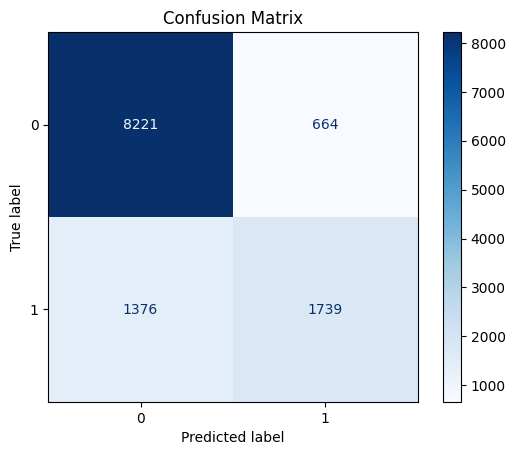

In [9]:

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [10]:
scores = calculate_scores(y_true, y_pred)
print(scores)

precision:	0.7237
recall:		0.5583
fscore:		0.6303
accuracy:	0.8300
tn: 8221	 fp: 664
fn: 1376	 tp: 1739


In [12]:
mlflow.end_run()
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="distilbert testing"
        ):
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("learning_rate", 5e-5)

    mlflow.log_metrics(scores.asdict())
    mlflow.set_tag("model", "distilbert")

    mlflow.log_table({"id": test["id"], "prediction": y_pred}, "predictions_distilbert.json")

    #log the model
    prediction_data = {
        "columns": ["id", "prediction"],
        "data": [[id_, pred.tolist()] for id_, pred in zip(test["id"], y_pred)]
    }
    # Save to a JSON file
    predictions_file = r"../resource/mlflow/distilbert/predictions.json"
    with open(predictions_file, "w") as f:
        json.dump(prediction_data, f, indent=4)
        
    # Log the JSON file as an artifact
    mlflow.log_artifact(predictions_file)
        
    # Simulate model registration
    mlflow.set_tag("registered_model_name", "distilbert")
    mlflow.set_tag("model_alias", "current")

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/predictions_distilbert.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="distilbert") 


client().set_registered_model_alias("distilbert", "current", registered_model.version)

Successfully registered model 'distilbert'.
Created version '1' of model 'distilbert'.
